In [1]:
%cd ../..

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-


In [2]:
import os
import shutil

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from src.forecasting.ml_forecasting import (
    MissingValueConfig,
    calculate_metrics,
)
from src.utils import plotting_utils
from tqdm.autonotebook import tqdm
from src.forecasting.ml_forecasting import calculate_metrics
from src.utils import ts_utils

%load_ext autoreload
%autoreload 2
np.random.seed(42)
tqdm.pandas()

C:\Users\ManuJoseph\OneDrive - Thoucentric\Work\Projects\Playground\AdvancedTimeSeriesForecastingBook\Github\Modern-Time-Series-Forecasting-with-Python-\src\utils\data_utils.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_12", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")

## Utility Functions

In [4]:
def format_plot(fig, legends=None, xlabel="Time", ylabel="Value", title="", font_size=15):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t: t.update(name=next(names)))
    fig.update_layout(
        autosize=False,
        width=900,
        height=500,
        title_text=title,
        title={"x": 0.5, "xanchor": "center", "yanchor": "top"},
        titlefont={"size": 20},
        legend_title=None,
        legend=dict(
            font=dict(size=font_size),
            orientation="h",
            yanchor="bottom",
            y=0.98,
            xanchor="right",
            x=1,
        ),
        yaxis=dict(
            title_text=ylabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        ),
        xaxis=dict(
            title_text=xlabel,
            titlefont=dict(size=font_size),
            tickfont=dict(size=font_size),
        )
    )
    return fig

In [5]:
from itertools import cycle


def plot_forecast(pred_df, forecast_columns, forecast_display_names=None):
    if forecast_display_names is None:
        forecast_display_names = forecast_columns
    else:
        assert len(forecast_columns) == len(forecast_display_names)
    mask = ~pred_df[forecast_columns[0]].isnull()
    colors = [
        "rgba(" + ",".join([str(c) for c in plotting_utils.hex_to_rgb(c)]) + ",<alpha>)"
        for c in px.colors.qualitative.Plotly
    ]
    act_color = colors[0]
    colors = cycle(colors[1:])
    fig = go.Figure()
    fig.add_trace(
        go.Scatter(
            x=pred_df[mask].index,
            y=pred_df[mask].energy_consumption,
            mode="lines",
            line=dict(color=act_color.replace("<alpha>", "0.9")),
            name="Actual Consumption",
        )
    )
    for col, display_col in zip(forecast_columns, forecast_display_names):
        fig.add_trace(
            go.Scatter(
                x=pred_df[mask].index,
                y=pred_df.loc[mask, col],
                mode="lines",
                line=dict(dash="dot", color=next(colors).replace("<alpha>", "1")),
                name=display_col,
            )
        )
    return fig

def highlight_abs_min(s, props=''):
    return np.where(s == np.nanmin(np.abs(s.values)), props, '')

## Reading the data

In [6]:
#Reading the missing value imputed and train test split data
train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
# Read in the Validation dataset as test_df so that we predict on it
test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
# test_df = pd.read_parquet(preprocessed/"block_0-7_test_missing_imputed_feature_engg.parquet")

In [ ]:
target = "energy_consumption"
index_cols = ["LCLid", "timestamp"]

In [ ]:
# Setting the indices
train_df.set_index(index_cols, inplace=True, drop=False)
test_df.set_index(index_cols, inplace=True, drop=False)

# Running Seq2Seq Models on a Sample Household

## Selecting the sample data and metrics

In [ ]:
sample_train_df = train_df.xs("MAC000193")
sample_test_df = test_df.xs("MAC000193")
# Creating a pred_df with actuals
pred_df = pd.concat([sample_train_df[[target]], sample_test_df[[target]]])

Split Train into Train and Validation and combine everything together into a single dataframe

In [ ]:
sample_val_df = sample_train_df.loc["2013-12"]
sample_train_df = sample_train_df.loc[:"2013-11"]

sample_train_df['type'] = "train"
sample_val_df['type'] = "val"
sample_test_df['type'] = "test"
sample_df = pd.concat([sample_train_df[[target, "type"]], sample_val_df[[target, "type"]], sample_test_df[[target, "type"]]])
sample_df.head()

energy_consumption   type
timestamp                                     
2012-01-01 00:00:00               0.368  train
2012-01-01 00:30:00               0.386  train
2012-01-01 01:00:00               0.170  train
2012-01-01 01:30:00               0.021  train
2012-01-01 02:00:00               0.038  train

### Loading the Forecast and metrics from Single Step RNN

In [ ]:
pred_df = pd.read_pickle(output/"dl_single_step_prediction_val_df_MAC000193.pkl")
metric_record = joblib.load(output/"dl_single_step_metrics_val_df_MAC000193.pkl")

## Loading the necessary classes

In [12]:
from src.dl.dataloaders import TimeSeriesDataModule
from src.dl.models import RNNConfig, Seq2SeqConfig, Seq2SeqModel
import pytorch_lightning as pl
import torch
# For reproduceability set a random seed
pl.seed_everything(42)

Global seed set to 42


42

### Creating the datamodule which splits and formats the data into windows

In [13]:
HORIZON = 1
WINDOW = 48

In [14]:
datamodule = TimeSeriesDataModule(data = sample_df[[target]],
        n_val = sample_val_df.shape[0],
        n_test = sample_test_df.shape[0],
        window = WINDOW, # giving enough memory to capture daily seasonality
        horizon = HORIZON, # single step
        normalize = "global", # normalizing the data
        batch_size = 32,
        num_workers = 0)
datamodule.setup()

### LSTM-FC Seq2Seq

In [15]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2fc_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="FC",
    encoder_params=encoder_config,
    decoder_params={"window_size": WINDOW, "horizon":HORIZON},
    decoder_use_all_hidden=False,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2fc_config)

In [16]:
# Getting a batch from the train_dataloader
for batch in datamodule.train_dataloader():
    x, y = batch
    break
print("Shape of x: ",x.shape)
print("Shape of y: ",y.shape)

Shape of x:  torch.Size([32, 48, 1])
Shape of y:  torch.Size([32, 1, 1])


In [17]:
# Running the batch through the model
# We expect two outputs - the first one is the forecast and second is the corresponding target
y_hat, y = model(batch)
print("Shape of y_hat: ",y_hat.shape)
print("Shape of y: ",y.shape)

Shape of y_hat:  torch.Size([32, 1, 1])
Shape of y:  torch.Size([32, 1, 1])


In [15]:
trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | Linear  | 257   
2 | loss    | MSELoss | 0     
------------------------------------
924 K     Trainable params
0         Non-trainable params
924 K     Total params
3.700     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [16]:
tag = f"{rnn2fc_config.encoder_type}_{rnn2fc_config.decoder_type}_{'all_hidden' if rnn2fc_config.decoder_use_all_hidden else 'last_hidden'}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(sample_test_df[target], pred_df_[tag], tag, pd.concat([sample_train_df[target],sample_val_df[target]]))
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 1049it [00:00, ?it/s]

In [17]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

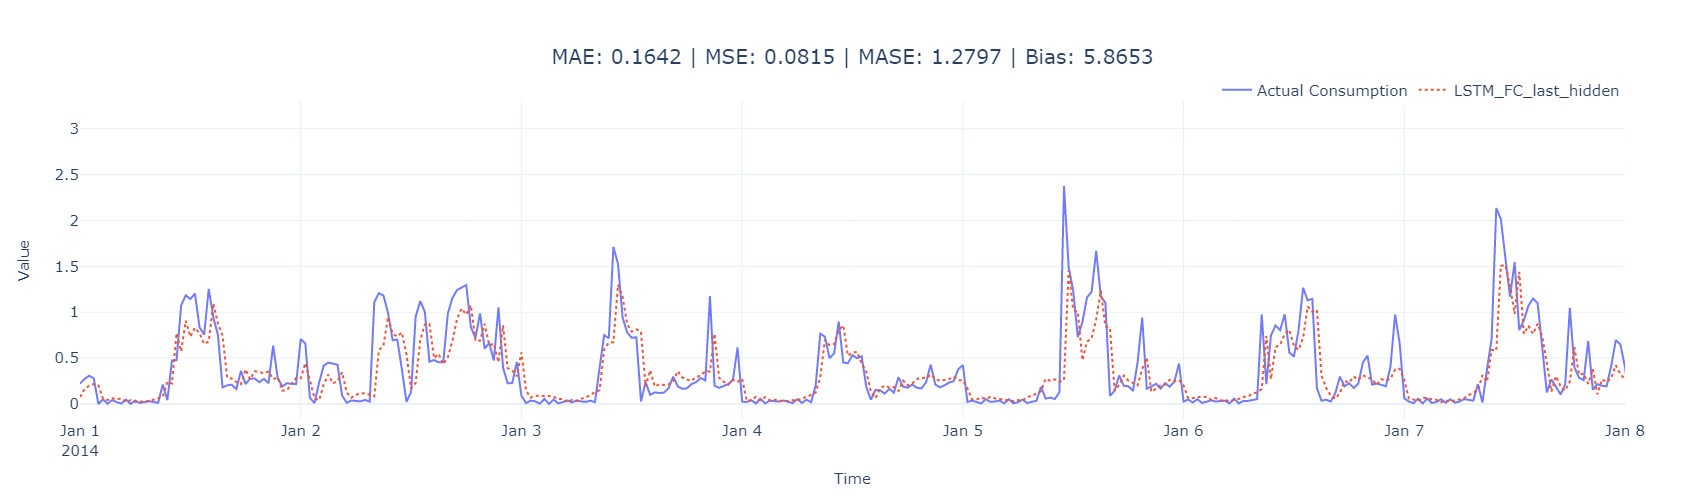

In [18]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

### LSTM-FC Seq2Seq use all hidden

In [19]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2fc_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="FC",
    encoder_params=encoder_config,
    decoder_params={"window_size": WINDOW, "horizon":HORIZON},
    decoder_use_all_hidden=True,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2fc_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | Linear  | 12.3 K
2 | loss    | MSELoss | 0     
------------------------------------
936 K     Trainable params
0         Non-trainable params
936 K     Total params
3.748     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



In [20]:
tag = f"{rnn2fc_config.encoder_type}_{rnn2fc_config.decoder_type}_{'all_hidden' if rnn2fc_config.decoder_use_all_hidden else 'last_hidden'}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(sample_test_df[target], pred_df_[tag], tag, pd.concat([sample_train_df[target],sample_val_df[target]]))
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1049it [00:00, ?it/s]

In [21]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

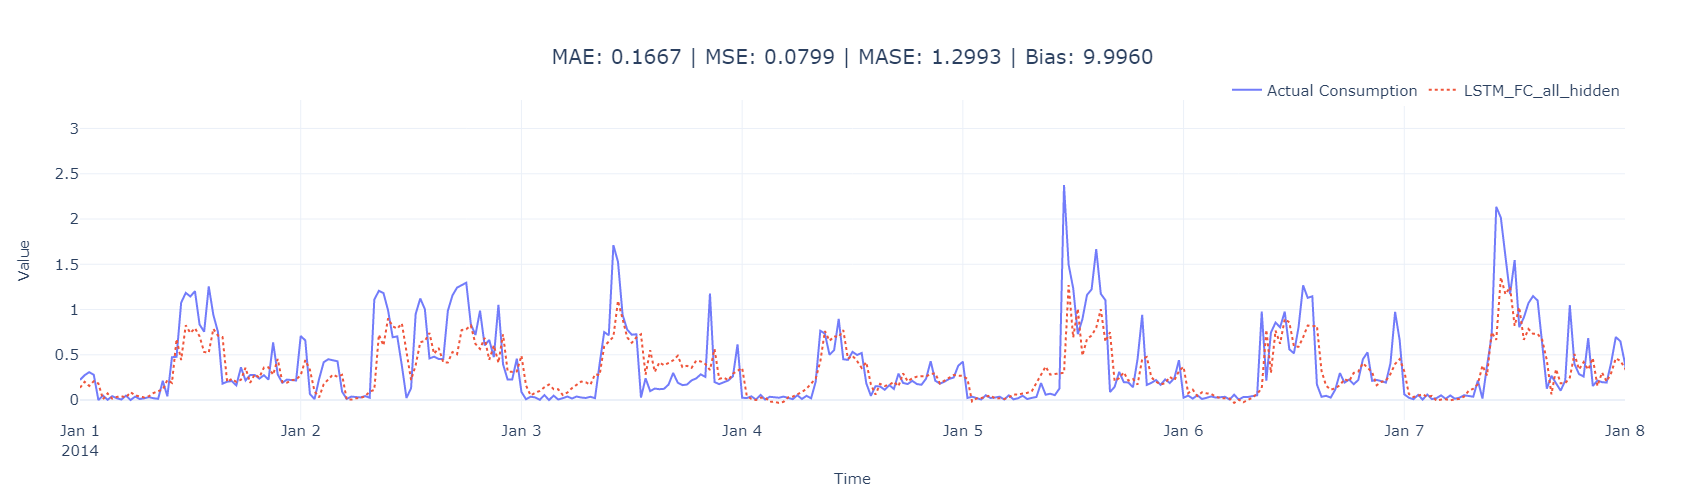

In [22]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

### LSTM-LSTM Seq2Seq

In [23]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2rnn_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="LSTM",
    encoder_params=encoder_config,
    decoder_params=encoder_config,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2rnn_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | LSTM    | 924 K 
2 | fc      | Linear  | 257   
3 | loss    | MSELoss | 0     
------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.398     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



In [24]:
tag = f"{rnn2rnn_config.encoder_type}_{rnn2rnn_config.decoder_type}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(sample_test_df[target], pred_df_[tag], tag, pd.concat([sample_train_df[target],sample_val_df[target]]))
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1049it [00:00, ?it/s]

In [25]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

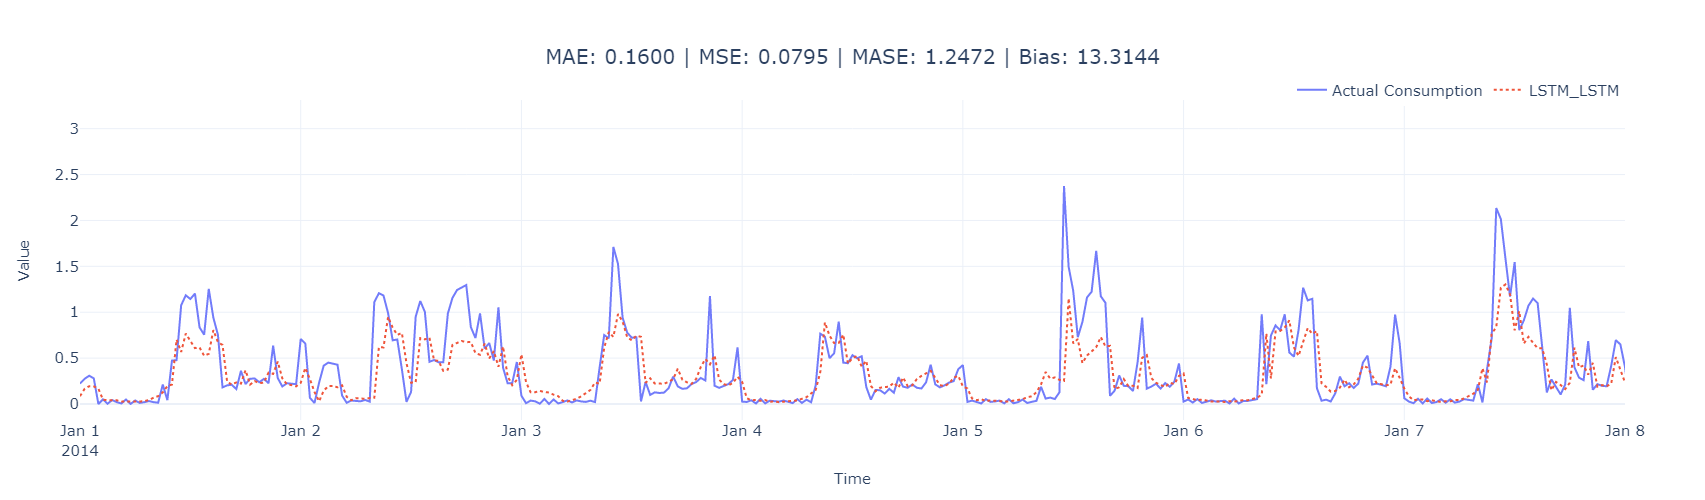

In [26]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

## Multi-Step Prediction

In [27]:
HORIZON = 48
WINDOW = 48*2

In [28]:
datamodule = TimeSeriesDataModule(data = sample_df[[target]],
        n_val = sample_val_df.shape[0],
        n_test = sample_test_df.shape[0],
        window = WINDOW, # giving enough memory to capture daily seasonality
        horizon = HORIZON, # single step
        normalize = "global", # normalizing the data
        batch_size = 32,
        num_workers = 0)
datamodule.setup()

### LSTM-FC Seq2Seq Last Hidden

In [29]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2fc_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="FC",
    encoder_params=encoder_config,
    decoder_params={"window_size": WINDOW, "horizon":HORIZON},
    decoder_use_all_hidden=False,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2fc_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | Linear  | 12.3 K
2 | loss    | MSELoss | 0     
------------------------------------
937 K     Trainable params
0         Non-trainable params
937 K     Total params
3.748     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [30]:
tag = f"MultiStep {rnn2fc_config.encoder_type}_{rnn2fc_config.decoder_type}_{'all_hidden' if rnn2fc_config.decoder_use_all_hidden else 'last_hidden'}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Selecting forward predictions of HORIZON timesteps, every HORIZON timesteps and flattening it
pred = pred[0::48].ravel()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(
    sample_test_df[target],
    pred_df_[tag],
    tag,
    pd.concat([sample_train_df[target], sample_val_df[target]]),
)
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1046it [00:00, ?it/s]

In [31]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

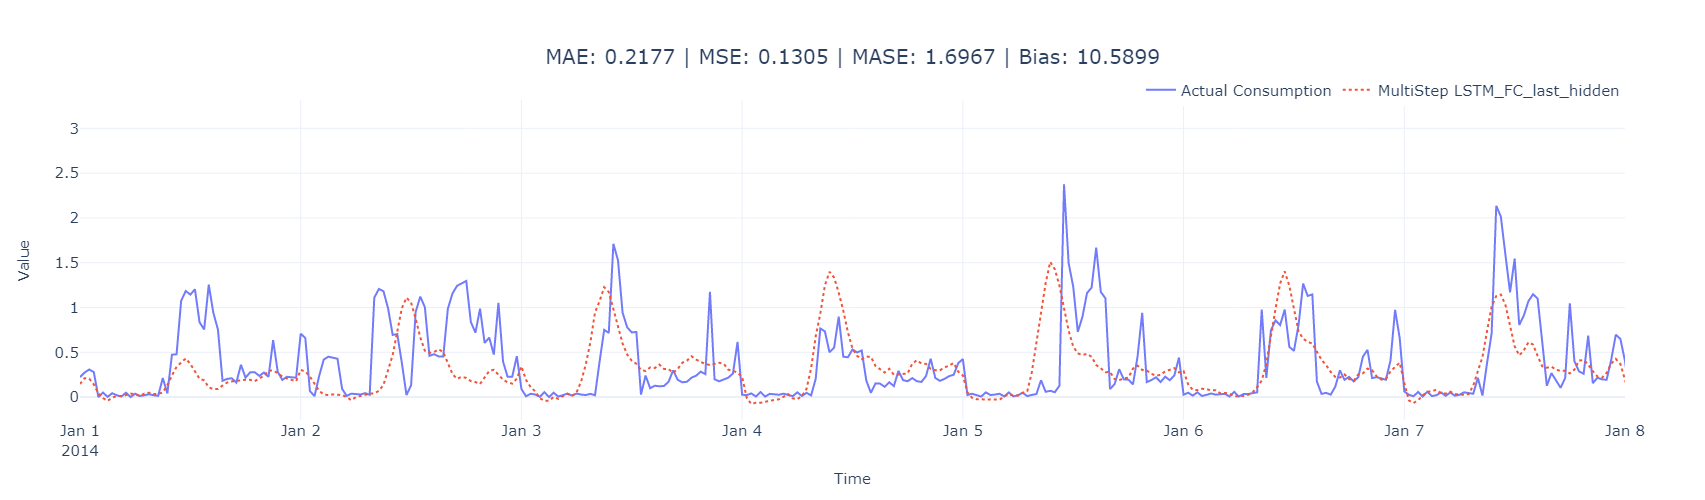

In [32]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

### LSTM-FC Seq2Seq All Hidden

In [33]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2fc_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="FC",
    encoder_params=encoder_config,
    decoder_params={"window_size": WINDOW, "horizon":HORIZON},
    decoder_use_all_hidden=True,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2fc_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | Linear  | 1.2 M 
2 | loss    | MSELoss | 0     
------------------------------------
2.1 M     Trainable params
0         Non-trainable params
2.1 M     Total params
8.417     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



In [34]:
tag = f"MultiStep {rnn2fc_config.encoder_type}_{rnn2fc_config.decoder_type}_{'all_hidden' if rnn2fc_config.decoder_use_all_hidden else 'last_hidden'}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Selecting forward predictions of HORIZON timesteps, every HORIZON timesteps and flattening it
pred = pred[0::48].ravel()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(
    sample_test_df[target],
    pred_df_[tag],
    tag,
    pd.concat([sample_train_df[target], sample_val_df[target]]),
)
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1046it [00:00, ?it/s]

In [35]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

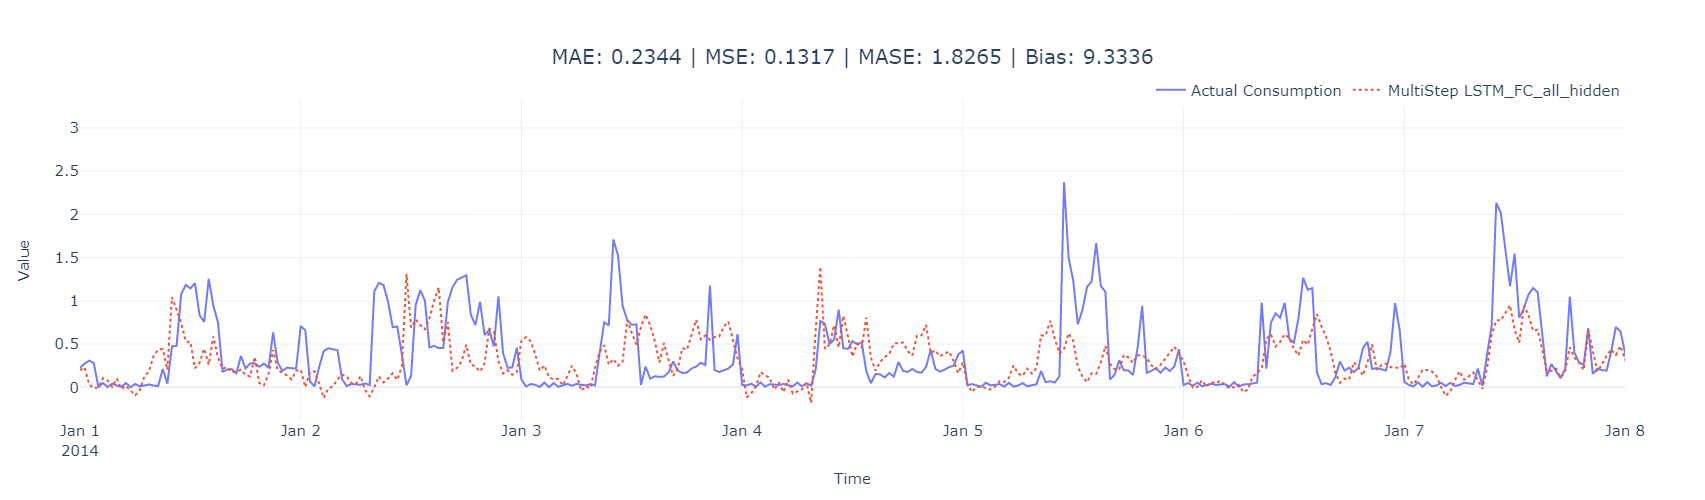

In [36]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

### LSTM-RNN Seq2Seq No Teacher Forcing

In [37]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2rnn_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="LSTM",
    encoder_params=encoder_config,
    decoder_params=encoder_config,
    teacher_forcing_ratio=0.0,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2rnn_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | LSTM    | 924 K 
2 | fc      | Linear  | 257   
3 | loss    | MSELoss | 0     
------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.398     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



In [38]:
tag = f"MultiStep {rnn2rnn_config.encoder_type}_{rnn2rnn_config.decoder_type}_teacher_forcing_{rnn2rnn_config.teacher_forcing_ratio}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Selecting forward predictions of HORIZON timesteps, every HORIZON timesteps and flattening it
pred = pred[0::48].ravel()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(sample_test_df[target], pred_df_[tag], tag, pd.concat([sample_train_df[target],sample_val_df[target]]))
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1046it [00:00, ?it/s]

In [39]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

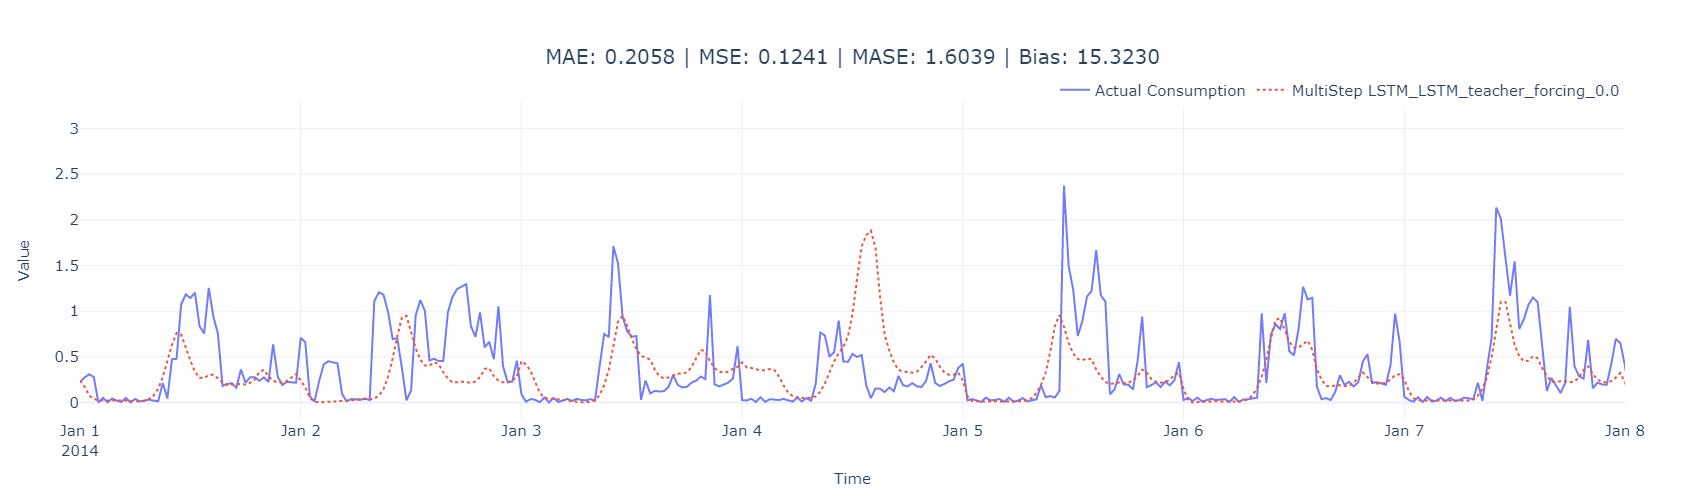

In [40]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()

### LSTM-RNN Seq2Seq With Teacher Forcing

In [41]:
encoder_config = RNNConfig(
    input_size=1,
    hidden_size=128,
    num_layers=3,
    bidirectional=True,
).__dict__
rnn2rnn_config = Seq2SeqConfig(
    encoder_type="LSTM",
    decoder_type="LSTM",
    encoder_params=encoder_config,
    decoder_params=encoder_config,
    teacher_forcing_ratio=0.5,
    learning_rate=1e-3,
)

model = Seq2SeqModel(rnn2rnn_config)

trainer = pl.Trainer(
    auto_select_gpus=True,
    gpus=-1,
    min_epochs=5,
    max_epochs=100,
    callbacks=[pl.callbacks.EarlyStopping(monitor="valid_loss", patience=3)],
)
trainer.fit(model, datamodule)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | encoder | LSTM    | 924 K 
1 | decoder | LSTM    | 924 K 
2 | fc      | Linear  | 257   
3 | loss    | MSELoss | 0     
------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.398     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

Global seed set to 42
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\core\datamodule.py:469: LightningDeprecationWarning:

DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.



In [42]:
tag = f"MultiStep {rnn2rnn_config.encoder_type}_{rnn2rnn_config.decoder_type}_teacher_forcing_{rnn2rnn_config.teacher_forcing_ratio}"
pred = trainer.predict(model, datamodule.test_dataloader())
# pred is a list of outputs, one for each batch
pred = torch.cat(pred).squeeze().detach().numpy()
# Selecting forward predictions of HORIZON timesteps, every HORIZON timesteps and flattening it
pred = pred[0::48].ravel()
# Apply reverse transformation because we applied global normalization
pred = pred * datamodule.train.std + datamodule.train.mean
pred_df_ = pd.DataFrame({tag: pred}, index=sample_test_df.index)
pred_df = pred_df.join(pred_df_)
metrics = calculate_metrics(sample_test_df[target], pred_df_[tag], tag, pd.concat([sample_train_df[target],sample_val_df[target]]))
metric_record.append(metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\ManuJoseph\miniconda3\envs\modern_ts_v3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning:

The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Predicting: 1046it [00:00, ?it/s]

In [43]:
formatted = pd.DataFrame(metric_record).style.format({"MAE": "{:.4f}", 
                          "MSE": "{:.4f}", 
                          "MASE": "{:.4f}", 
                          "Forecast Bias": "{:.2f}%"})
formatted.highlight_min(color='lightgreen', subset=["MAE","MSE","MASE"]).apply(highlight_abs_min, props='color:black;background-color:lightgreen', axis=0, subset=['Forecast Bias'])

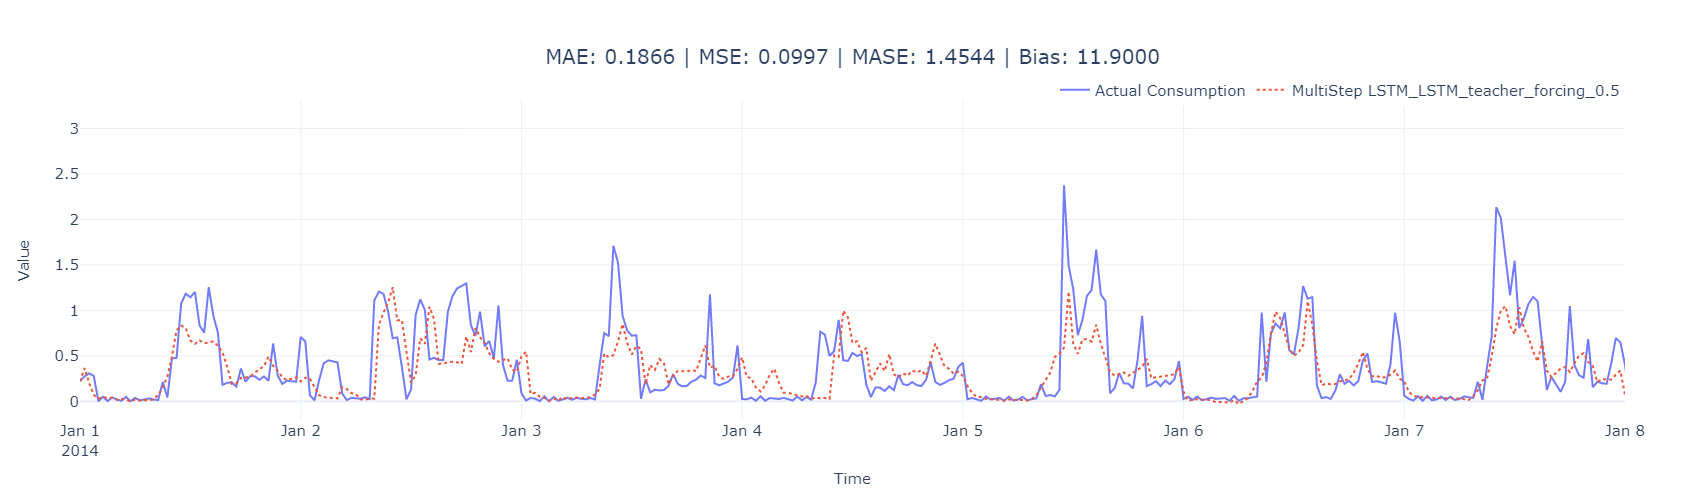

In [44]:
fig = plot_forecast(pred_df, forecast_columns=[tag], forecast_display_names=[tag])
fig = format_plot(fig, title=f"MAE: {metrics['MAE']:.4f} | MSE: {metrics['MSE']:.4f} | MASE: {metrics['MASE']:.4f} | Bias: {metrics['Forecast Bias']:.4f}")
fig.update_xaxes(type="date", range=["2014-01-01", "2014-01-08"])
fig.write_image(f"imgs/chapter_12/{tag}.png")
fig.show()